In [9]:
from fastai.collab import *
from fastai.tabular.all import *
from fastai.data.external import untar_data, URLs

In [13]:
set_seed(42)
path = untar_data(URLs.ML_100k)

In [14]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                     names=['user', 'movie', 'rating', 'timestamp'])


ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Die leeren Zellen in dieser Tabelle sind genau das, was unser Modell vorhersagen soll

### Wie Funktioniert die Vorharsage?
Stell dir vor, wir wüssten über jeden Nutzer, wie sehr er auf verschiedene Kategorien wie Genre, Alter des Films, bevorzugte Schauspieler oder Regisseure steht. Und wir wüssten dasselbe über die Filme. Dann könnten wir einfach diese Eigenschaften miteinander multiplizieren und wüssten, wie gut ein Film zu einem Nutzer passt.

Wichtig: Auch wenn wir diese Faktoren nicht explizit kennen, nehmen wir an, dass es unsichtbare (latente) Faktoren gibt, die genau diese Vorlieben repräsentieren.

Beispiel:

In [19]:
# Latente Faktoren eines Films (Sci-Fi, Action, Alt)
last_skywalker = np.array([0.98, 0.9, -0.9])

# Latente Faktoren eines klassischen Films
casablanca = np.array([-0.99, -0.3, 0.8])

# Latente Vorlieben eines Nutzers für diese Eigenschaften
user1 = np.array([0.9, 0.8, -0.6])

# relevanz berechnen  (Skalarprodukt (engl. dot product))
last_skywalker_result = (user1 * last_skywalker).sum()

casablanca_result = (user1 * casablanca).sum()

print(f"Casablance result is: {casablanca_result}")
print(f"Last Skywalker result is: {last_skywalker_result}")


Casablance result is: -1.611
Last Skywalker result is: 2.1420000000000003


### Wichtiger Punkt:

Da wir nicht wissen, was genau die latenten Faktoren sind, und auch nicht, wie man sie für jeden Nutzer und Film bewertet, müssen wir sie lernen.
Das ist die Aufgabe unseres Machine-Learning-Modells.

## Learning the Latent Factors

### Schritt 1: Parameter zufällig initialisieren
Wir starten mit zufälligen Werten – und zwar für:

* jeden Nutzer (User)

* jeden Film (Movie)

Diese zufälligen Werte sind latente Faktoren. Für jedes Nutzer-Film-Paar lernen wir diese versteckten Eigenschaften, z. B.:

* Wie sehr ein Nutzer Actionfilme mag

* Wie viel Action ein bestimmter Film hat



Beispiel:
Wir sagen, wir verwenden 5 latente Faktoren (könnte auch mehr oder weniger sein). Dann bekommt jeder Nutzer einen Vektor mit 5 Zahlen, ebenso jeder Film.

### Schritt 2: Vorhersagen berechnen
Die Vorhersage der Bewertung erfolgt durch das Skalarprodukt (Dot Product) der Nutzer- und Filmvektoren:


Code: 
* predicted_rating = np.dot(user_vector, movie_vector)

Beispiel:
* User1 liebt Action (Faktor1 = 0.9)

* MovieA hat viel Action (Faktor1 = 0.8)
→ Produkt = 0.9 × 0.8 = hoch ⇒ starke Übereinstimmung

* Umgekehrt: Wenn User1 Action nicht mag (Faktor1 = –0.9), aber der Film viel Action hat (+0.8) ⇒ Produkt = –0.72 ⇒ niedrige Bewertung



### Schritt 3: Verlust berechnen (Loss)
Jetzt vergleichen wir unsere Vorhersagen mit den echten Bewertungen der Nutzer (z. B. 4 von 5 Sternen).

Wir verwenden dafür z. B. MSE (Mean Squared Error):

* loss = (true_rating - predicted_rating) ** 2

### Schritt 4: Optimieren mit SGD
Jetzt wenden wir Stochastic Gradient Descent (SGD) an:

Für jedes Nutzer-Film-Paar:

* Vorhersage berechnen

* Fehler ableiten (Gradient)

* Gewichte anpassen (latent factors updaten)

* Schrittweite = Lernrate

Wiederholen wir das viele Male, verbessern sich:

* der Loss

* die Vorhersagen

* unsere Empfehlungen 🎯



### Creating the DataLoaders

In [20]:
movies = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)

movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [21]:
ratings = ratings.merge(movies) # Das führt automatisch einen Inner Join auf der gemeinsamen Spalte movie durch.

In [22]:
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)
3,244,51,2,880606923,Legends of the Fall (1994)
4,166,346,1,886397596,Jackie Brown (1997)


In [24]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,782,Starship Troopers (1997),2
1,943,Judge Dredd (1995),3
2,758,Mission: Impossible (1996),4
3,94,Farewell My Concubine (1993),5
4,23,Psycho (1960),4
5,296,Secrets & Lies (1996),5
6,940,"American President, The (1995)",4
7,334,Star Trek VI: The Undiscovered Country (1991),1
8,380,Braveheart (1995),4
9,690,So I Married an Axe Murderer (1993),1


In [26]:
# dls.classes

### Mathematisches Modell: Latente Faktoren als Matrizen

In [27]:
n_users = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

Jeder Nutzer und jeder Film erhält einen Vektor mit 5 Werten. Diese Vektoren (Faktoren) beschreiben z. B. Genre, Filmstil, Alter, Dialogtiefe usw.

In [29]:
user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [35]:
print(f"User factor shape {user_factors.shape}")
print(f"Movie factor shape {movie_factors.shape}")

User factor shape torch.Size([944, 5])
Movie factor shape torch.Size([1665, 5])


In [36]:
user_factors

tensor([[-1.0827,  0.2138,  0.9310, -0.2739, -0.4359],
        [-0.5195,  0.7613, -0.4365,  0.1365,  1.3300],
        [-1.2804,  0.0705,  0.6489, -1.2110,  1.8266],
        ...,
        [ 0.8009, -0.4734, -0.8962, -0.7348, -0.0246],
        [ 0.3354, -0.8262, -0.1541,  0.4699,  0.4873],
        [ 2.4054, -0.2156, -1.4126, -0.2467,  1.0571]])

In [41]:
user_factors[:, 0].shape # Alles in die erste Spalte

torch.Size([944])

Statt One-Hot-Vektoren zu verwenden (was ineffizient ist), nutzt PyTorch nn.Embedding – ein Layer, der effizient in solche Matrizen „indiziert“:


* embedding = nn.Embedding(num_embeddings=n_users, embedding_dim=n_factors)

Wenn du embedding(3) aufrufst, bekommst du direkt den Vektor für Nutzer Nr. 3 – genau so, als würdest du das Skalarprodukt mit einem One-Hot-Vektor machen, aber viel effizienter.

Das nennt man Embedding:
Das Produkt aus One-Hot und Embedding-Matrix – effizient als Indexierung umgesetzt

### Was passiert, wenn wir mehr oder weniger als 5 Dimensionen wählen?
Das ist die Anzahl der latenten Faktoren – also, wie viele „unsichtbare Eigenschaften“ ein User oder Film haben darf.

#### Weniger Dimensionen (z. B. 2 oder 3):

* Weniger Kapazität → kann nur wenige Unterschiede zwischen Nutzern und Filmen erfassen.

* Schnelleres Training, aber unterfittet oft.

#### Mehr Dimensionen (z. B. 10, 20 oder 100):

* Höhere Kapazität → kann komplexere Vorlieben und Inhalte erfassen.

* Höheres Risiko von Overfitting, langsameres Training.

#### Tradeoff:

* Wenig Dimensionen = einfacher, schlechtere Genauigkeit

* Viel Dimensionen = genauer, aber overfitting möglich

➡Die optimale Zahl findest du durch Validierung: verschiedene Modelle ausprobieren und schauen, was am besten generalisiert.

### Collaborative Filtering from Scratch

In [57]:
class DotProduct(Module):
    def __init__(self, n_user, n_movies, n_factors):
        # eder Nutzer und jeder Film bekommt einen Vektor mit n_factors Latenten
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        
    def forward(self, x):
        users = self.user_factors(x[:, 0])
        movies = self.movie_factors(x[:, 1])
        return (users * movies).sum(dim=1)  

In [58]:
x, y = dls.one_batch()
x.shape, y.shape

(torch.Size([64, 2]), torch.Size([64, 1]))

#### Training 

#### 1. "One Cycle Policy" – Die Idee
Die „One Cycle Policy“ stammt von Leslie Smith und funktioniert so:

Lernrate:
* Startet niedrig, dann steigt sie auf ein Maximum (lr_max),

* und fällt dann wieder langsam ab.

Momentum:
* Momentum verhält sich umgekehrt zur Lernrate:

* (Wenn Lernrate steigt → Momentum sinkt)

* (Wenn Lernrate fällt → Momentum steigt wieder)

Dadurch lernt das Netzwerk schneller, vermeidet schlechte Minima und generalisiert besser.

#### 2. Warum ist das gut?
* Reduziert Overfitting, weil am Ende eine kleine Lernrate genutzt wird.

* Exploration am Anfang (große Lernrate) hilft dem Modell, „weite Täler“ im Fehlerraum zu finden → besser generalisierende Lösungen.

* Bewährte Praxis in NLP, CV, etc.

In [60]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.343954,1.340800,00:05
1,1.025920,1.085733,00:04
2,0.877067,0.985438,00:04
3,0.773130,0.900094,00:04
4,0.748980,0.877117,00:04


#### Bias hinzufügen

Damit deine Modellausgabe (pred_rating) immer im erwarteten Wertebereich liegt, z. B.:

* Bei Filmratings: zwischen 0 und 5.5 Sternen
→ sonst könnten unrealistische Werte wie -3 oder 9 entstehen!

* sigmoid(2.0) ≈ 0.88
* sigmoid(0.0) = 0.5
* sigmoid(-2.0) ≈ 0.12

Skaliert auf 0–5.5:
* 0.88 * 5.5 ≈ 4.84
* 0.5  * 5.5 = 2.75
* 0.12 * 5.5 ≈ 0.66


In [62]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)
     

In [63]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.852983,0.938410,00:05
1,0.549487,0.915182,00:05
2,0.404705,0.951297,00:06
3,0.306621,0.965349,00:05
4,0.291226,0.965802,00:05


### Was ist Weight Decay?

**Weight Decay** bedeutet:  
Man fügt zur Verlustfunktion einen zusätzlichen **Strafterm** hinzu:

$$
\text{Loss}_{\text{neu}} = \text{Loss} + \text{wd} \cdot \sum (\text{alle Gewichte})^2
$$

Dieser Term bestraft **große Gewichtswerte**, sodass das Modell **kleinere (glattere) Lösungen** bevorzugt.

---

#### Warum hilft das gegen Overfitting?

Stell dir eine einfache Parabel vor:

$$
y = a \cdot x^2
$$

- Wenn \( a \) **groß** ist → die Kurve ist **steil und scharf** → hohe Komplexität  
- Wenn \( a \) **klein** ist → die Kurve ist **flacher** → bessere Generalisierung

**Große Gewichte** → scharfe, überkomplexe Funktionen → **Overfitting**  
**Kleine Gewichte** → glattere Funktionen → **bessere Generalisierung**

---

#### Mathematisch hinter den Kulissen

Anstatt die quadratischen Terme **explizit** zur Loss-Funktion zu addieren (ineffizient), nutzt man:

$$
\frac{d}{dp}(p^2) = 2p
$$

Das heißt:  
Beim Backpropagation-Schritt wird der **Gradient einfach modifiziert**:

$$
\text{Gradient} += \text{wd} \cdot 2 \cdot \text{Gewicht}
$$

In der Praxis wird einfach:

$$
\text{wd} \cdot 2
$$

verwendet und direkt im Optimierer berücksichtigt.


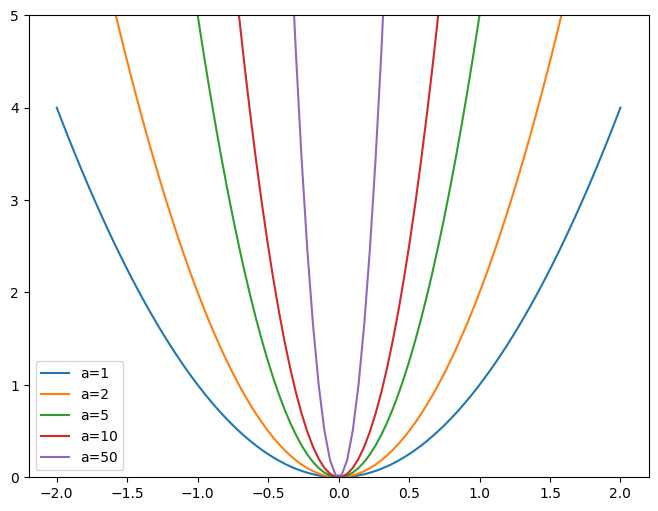

In [64]:
x = np.linspace(-2,2,100)
a_s = [1,2,5,10,50] 
ys = [a * x**2 for a in a_s]
_,ax = plt.subplots(figsize=(8,6))
for a,y in zip(a_s,ys): ax.plot(x,y, label=f'a={a}')
ax.set_ylim([0,5])
ax.legend();

In [65]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1) # Der Parameter wd=0.1 fügt die Regularisierung hinzu.

epoch,train_loss,valid_loss,time
0,0.889371,0.938958,00:05
1,0.667413,0.894071,00:05
2,0.532753,0.879208,00:05
3,0.452732,0.860240,00:05
4,0.435358,0.856967,00:05


## Creating Our Own Embedding Module

Wenn du ein normales Tensor-Attribut in ein nn.Module einfügst, dieses Tensor ist nicht trainierbar, weil PyTorch es nicht als Parameter erkennt.

In [66]:
class T(Module):
    def __init__(self):
        self.a = torch.ones(3)
        
L(T().parameters())

(#0) []

### Lösung 

In [67]:
class T(Module):
    def __init__(self):
        self.a = nn.Parameter(torch.ones(3))
        
L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

In [71]:
class T(Module):
    def __init__(self): self.a = nn.Linear(1, 3, bias=False)

t = T()
L(t.parameters())

(#1) [Parameter containing:
tensor([[ 0.4203],
        [ 0.7375],
        [-0.7119]], requires_grad=True)]

In [72]:
type(t.a.weight)

torch.nn.parameter.Parameter

### DotProductBias ohne Embedding

In [76]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

In [78]:
create_params([n_users, n_factors]).shape

torch.Size([944, 5])

In [87]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

In [88]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.889625,0.933394,00:05
1,0.641659,0.884612,00:05
2,0.529312,0.868454,00:05
3,0.458472,0.856043,00:05
4,0.419467,0.849821,00:05


## Interpreting Embeddings and Biases
hier geht es darum, was unser Modell eigentlich gelernt hat – also wie es denkt.
Auch wenn das Modell gut Empfehlungen macht, wollen wir verstehen:

* Was steckt hinter den Zahlen?

* Welche Filme mag das Modell automatisch eher – unabhängig vom Nutzerprofil?

* Was haben die Embeddings gelernt?


### Was sind Biases?
Bias-Werte (also „Verzerrungen“) sagen uns:

* Ob ein Film grundsätzlich gut oder schlecht ankommt – unabhängig vom User.

* D.h., auch wenn der Nutzer eigentlich passende Vorlieben hat, mag er diesen Film trotzdem (nicht).

In [90]:
# Filme mit dem niedrigsten Bias (also am unbeliebtesten)
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

['Grease 2 (1982)',
 'Showgirls (1995)',
 'Spice World (1997)',
 'Children of the Corn: The Gathering (1996)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)']

In [91]:
# Filme mit dem höchsten Bias (also besonders beliebt)
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Shawshank Redemption, The (1994)',
 "Schindler's List (1993)",
 'Rear Window (1954)',
 'Good Will Hunting (1997)',
 'Titanic (1997)']

### Embeddings direkt interpretieren?
Schwierig. Denn:

* Sie bestehen aus vielen Dimensionen (z. B. 50).

* Das ist nicht intuitiv für Menschen.

Lösung: PCA (Principal Component Analysis)

* PCA reduziert die Dimensionen.

* Ergebnis: Die wichtigsten Richtungen (also „Hauptachsen“) werden sichtbar.

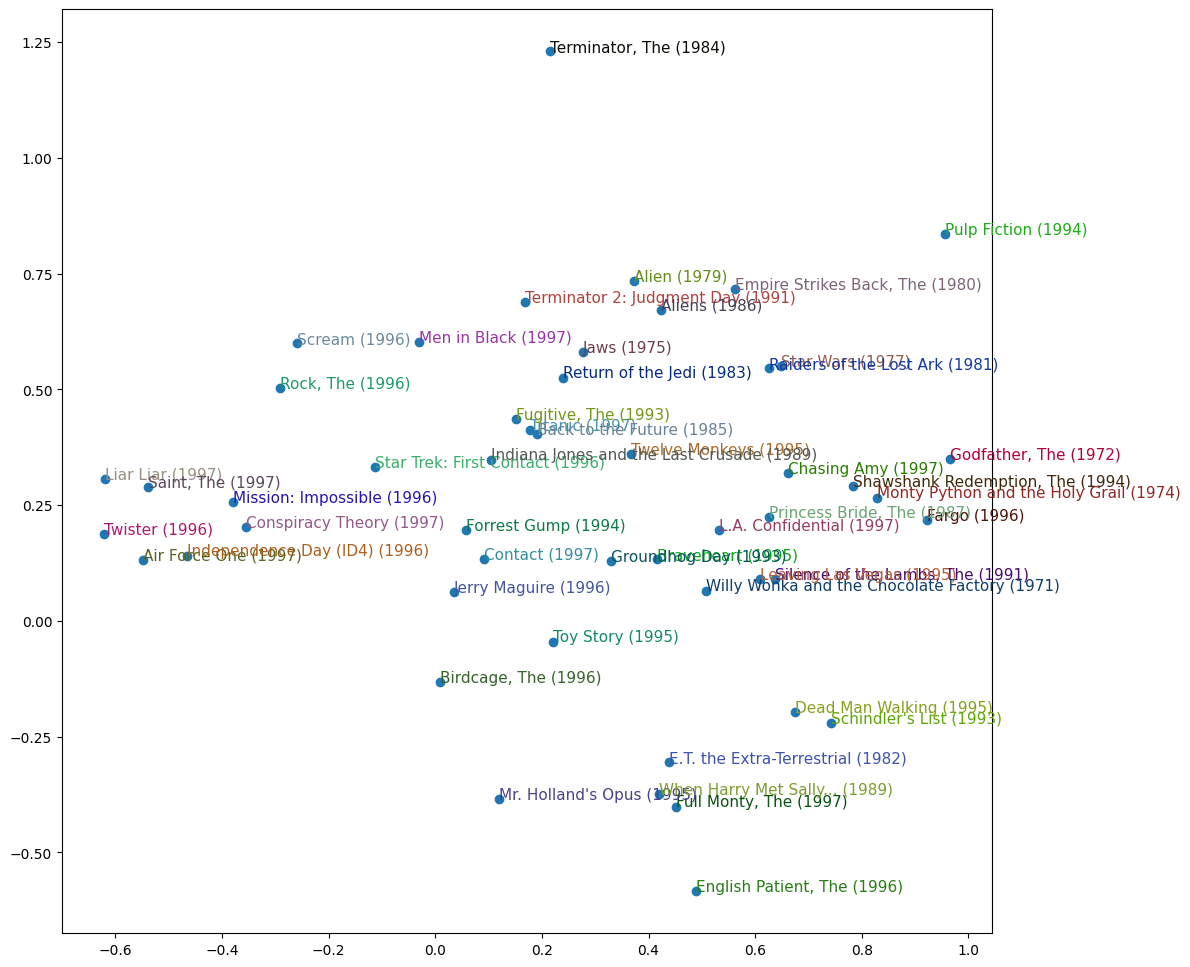

In [93]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

## Using fastai.collab

Ein bereits eingebautes, leistungsstarkes Modell nutzen, das genau dieselbe Architektur wie unser selbstgebautes Modell hat – aber in einer Zeile trainiert werden kann

In [98]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.905025,0.953261,00:05
1,0.688542,0.888006,00:05
2,0.546988,0.863869,00:05
3,0.451574,0.849659,00:05
4,0.453525,0.846385,00:05


In [100]:
# User-Latent-Vektoren
# Movie-Latent-Vektoren
# User-Biases
# Movie-Biases


learn.model 

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [101]:
#  Analyse der Bias-Werte
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

["Schindler's List (1993)",
 'Good Will Hunting (1997)',
 'Shawshank Redemption, The (1994)',
 'Rear Window (1954)',
 'Titanic (1997)']

## Embedding Distance (ähnliche Filme finden)
* Grundidee: Wenn zwei Filme sehr ähnliche Zuschauer anziehen, dann sind ihre Embedding-Vektoren ähnlich → also kleine Distanz im Vektorraum.

* Ähnlichkeit kann z. B. über den Kosinus der Winkel zwischen Vektoren gemessen werden.

Das heißt: Menschen, die „Silence of the Lambs“ mochten, mögen sehr wahrscheinlich auch „Dial M for Murder“ – obwohl das Modell nicht weiß, dass beide psychologische Thriller sind!

In [102]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]  # [0] wäre der Film selbst
dls.classes['title'][idx]

'You So Crazy (1994)'

## Bootstrapping a Collaborative Filtering Model
Wie machen wir Empfehlungen für neue Nutzer, die noch keine Bewertungen abgegeben haben?

## Bootstrapping a Collaborative Filtering Model

### Problem: Neue Nutzer oder Produkte haben keine Daten

Bevor wir überhaupt Empfehlungen aussprechen können, brauchen klassische kollaborative Modelle (wie unser Dot-Product-Modell) vergangene Bewertungen.  
Doch was passiert bei einem neuen Nutzer, der noch keinen einzigen Film bewertet hat?

---

### Lösungsmöglichkeiten:

**1. Durchschnitt nehmen (naiv)**  
→ Durchschnitt der Embedding-Vektoren aller Nutzer verwenden

*Aber:*  
Der Mittelwert ist oft nicht repräsentativ für echte Nutzer.  
Beispiel: Hohe Sci-Fi-Präferenz kombiniert mit niedriger Action-Priorität – kommt selten vor.

---

**2. Durchschnittlicher Beispielnutzer**  
→ Einen echten Nutzer mit „mittlerem Geschmack“ auswählen

Besser als der Mittelwert, aber noch sehr grob – keine Personalisierung.

---

**3. Tabellenmodell (Tabular Model) basierend auf Nutzer-Metadaten**  
→ Beste Option: Frage neue Nutzer beim Onboarding gezielt nach Vorlieben  
→ Trainiere dann ein Modell, das daraus die Embedding-Vektoren der Nutzer vorhersagt.

**Beispiel:**

Eingaben:
- Alter: 26  
- Lieblingsgenre: „Sci-Fi“  
- Lieblingsfilm: „Interstellar“  
- Geschlecht: Divers  

Ausgabe:
vektor = [0.78, 0.34, -0.92, ..., 0.15]
``



So entstehen personalisierte Embeddings für neue Nutzer, **ohne dass sie Bewertungen abgeben mussten**.

Viele Plattformen wie Netflix, Spotify oder Pandora nutzen genau diese Strategie.  
Deshalb wirst du beim Start gefragt:  
„Welche Genres magst du? Welche Künstler gefallen dir?“

---

### Achtung: Repräsentations-Bias

Ein ernstes Problem:

Wenn wenige Nutzer (z. B. Anime-Fans) besonders aktiv bewerten, beeinflussen sie stark das Modell.

→ Beliebtheit verzerrt sich Richtung „Anime“ – auch wenn das nur für 5 % der Nutzer gilt.

**Warum ist das gefährlich?**

→ Positive Feedback-Loops entstehen:
- Empfehlungsmodell bevorzugt Anime  
- Mehr Anime-Nutzer werden angezogen  
- Modell verstärkt diese Richtung weiter  
- Das System driftet völlig ab

**Resultat:** Divergenz zwischen Unternehmenswerten und dem Verhalten des Systems (z. B. bei YouTube- oder Facebook-Empfehlungen)

---

### Fazit und Praxis-Empfehlung

- Feedback-Schleifen sind die Regel, nicht die Ausnahme  
- Plane Monitoring, menschliche Kontrolle und vorsichtiges Rollout  
- Vermeide es, dem System blind zu vertrauen – implementiere Checks

---

### Das Modell basiert auf Probabilistic Matrix Factorization (PMF)

- Dot-Product + SGD-Lernen ≈ klassische Methode für Matrix-Faktorisierung  
- Robust, einfach, weit verbreitet


## Deep Learning für Collaborative Filtering

In [103]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [104]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1] + item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1)
        )
        self.y_range = y_range

    def forward(self, x):
        embs = self.user_factors(x[:,0]), self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

In [108]:
model = CollabNN(*embs)

In [109]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.926873,0.944816,00:06
1,0.868382,0.900016,00:06
2,0.813797,0.877195,00:06
3,0.781913,0.871063,00:06
4,0.759185,0.869204,00:06
